In [1]:
import torch
import scipy.io as scio
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual1d(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [2]:
net = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3), 
    nn.BatchNorm1d(64), nn.ReLU(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
    Residual1d(64, 64),
    Residual1d(64, 64),
    Residual1d(64, 128, use_1x1conv=True, strides=2),
    Residual1d(128, 128),
    Residual1d(128, 256, use_1x1conv=True, strides=2),
    Residual1d(256, 256),
    Residual1d(256, 512, use_1x1conv=True, strides=2),
    Residual1d(512, 512),
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 128))

In [3]:
data = scio.loadmat('./data_train.mat')

In [4]:
train_X=torch.tensor(data['train_X'])
train_y=torch.tensor(data['train_y'])
test_X=torch.tensor(data['test_X'])
test_y=torch.tensor(data['test_y'])
train_X=train_X.reshape(878,256,1,256)
train_y=train_y.reshape(878,256,128)
test_X=test_X.reshape(98,256,1,256)
test_y=test_y.reshape(98,256,128)
train_X=train_X.float()
train_y=train_y.float()
test_X=test_X.float()
test_y=test_y.float()

In [5]:
def evaluate_accuracy_gpu_dc(net, data_X, data_y, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    loss = nn.MSELoss()
    with torch.no_grad():
        for i in range(len(data_X)):
            X, y = data_X[i], data_y[i]
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            metric.add(l * X.shape[0], X.shape[0])
    return metric[0] / metric[1]

In [6]:
def train_dc(net, train_X, train_y, test_X, test_y, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'test loss'])
    timer, num_batches = d2l.Timer(), len(train_X)
    for epoch in range(num_epochs):
        # 训练损失之和，样本数
        metric = d2l.Accumulator(2)
        net.train()
        for i in range(len(train_X)):
            X, y = train_X[i], train_y[i]
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.sum().backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[1]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, None))
        test_l = evaluate_accuracy_gpu_dc(net, test_X, test_y)
        animator.add(epoch + 1, (None, test_l))
    print(f'train loss {train_l:.3f}, '
          f'test loss {test_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

train loss 0.024, test loss 0.029
23558.7 examples/sec on cuda:0


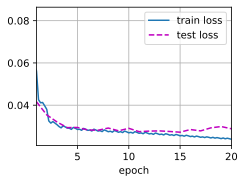

In [7]:
lr, num_epochs = 0.001, 20
train_dc(net, train_X, train_y, test_X, test_y, num_epochs, lr, d2l.try_gpu())

In [8]:
torch.save(net.state_dict(), 'dcnc.params')

In [2]:
net1 = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3), 
    nn.BatchNorm1d(64), nn.ReLU(),
    nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
    Residual1d(64, 64),
    Residual1d(64, 64),
    Residual1d(64, 128, use_1x1conv=True, strides=2),
    Residual1d(128, 128),
    Residual1d(128, 256, use_1x1conv=True, strides=2),
    Residual1d(256, 256),
    Residual1d(256, 512, use_1x1conv=True, strides=2),
    Residual1d(512, 512),
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(512, 128))
net1.load_state_dict(torch.load('dcnc.params'))
data = scio.loadmat('./f.mat')
data_X=torch.tensor(data['F'])
data_X=data_X.reshape(625,256,1,256)
data_y=torch.zeros(625,256,128)
data_X=data_X.float()
device=d2l.try_gpu()
net1.to(device)
net1.eval()
with torch.no_grad():
    for i, X in enumerate(data_X):
        X=X.to(device)
        y=net1(X)
        data_y[i]=y
data_y=data_y.reshape(160000,128)
data_Y=data_y.numpy()
scio.savemat('y.mat',{'myData':data_Y})